### Importando as libs e definindo as funções básicas

In [7]:
# 0.0. Importando as libs

from matplotlib.dates import DateFormatter, AutoDateLocator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# 0.1. Construindo a path de input e importanto o dataframe

script_path = os.getcwd()
cutting_string = "Scripts"

partes = script_path.split(cutting_string)
path_insumos = partes[0] + "Insumos\\Semi-tratado (v2)"

df = pd.read_excel(path_insumos + "\\Semitratado.xlsx")

# O intervalo de corte de outlier é uma variável que deve ser declarada a fim de agrupar os dados
# de x em x dias para detectar outliers nesse meio. A ideia é, com isso, suavizar a curva a medida
# que aumentamos o intervalo de corte de outlier, levando em conta que quanto maior a amostra, 
# mais discrepâncias serão detectadas.
intervalo_de_corte_outliers = 15

# Já o intervalo de agrupamento diz respeito mais a visualização dos dados em gráficos de linha.
# Ou seja, se eu quero diminuir o número de dados que são mostrados, eu utilizo essa variável para
# dizer qual o intervalo que irei fazer a média e, então, exibir a média no gráfico. 
intervalo_de_agrupamento = 15

# 1.0. Construindo a função que anula outliers

def anula_outliers(series):
    # Calcular o primeiro e terceiro quartis
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    # Calcular o IQR
    IQR = Q3 - Q1
    # Definir limites para considerar um dado como outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Substituir os outliers por NaN
    series[(series < lower_bound) | (series > upper_bound)] = np.nan
    return series

# 1.1. Construindo a função que seleciona as colunas e apaga os outliers dado o intervalo

def anula_outliers_colunas_selecionadas(df, colunas, intervalo_de_dias):

    if 'Data da Coleta' not in colunas:
        # Selecionar apenas as colunas desejadas

        # Criando uma cópia da lista original para não modificar a lista original
        colunas_modificadas = colunas.copy()
        colunas_modificadas.append('Data da Coleta')
        temp_df = df[colunas_modificadas].copy()

    else:
        temp_df = df[colunas].copy()
    
    # Garantir que a coluna 'Data da Coleta' está no formato datetime e usá-la como índice
    temp_df['Data da Coleta'] = pd.to_datetime(temp_df['Data da Coleta'], format='%Y%m%d')
    temp_df.set_index('Data da Coleta', inplace=True)

    # Agrupar dados por intervalo de dias e aplicar a função para substituir outliers por NaN em cada grupo
    temp_df = temp_df.resample(f'{intervalo_de_dias}D').apply(lambda x: anula_outliers(x))
    
    # Resetar o índice para voltar 'Data da Coleta' como uma coluna
    temp_df.reset_index(inplace=True)
    
    if 'Data da Coleta' not in colunas:
        # Selecionar apenas as colunas desejadas
        temp_df = temp_df[colunas].copy()
        
    else:
        pass

    return temp_df

# 1.2. Construindo a função de média os dados no intervalo

def media_intervalo(df, intervalo_de_dias):

    temp_df = df.copy()

    # Garantir que a coluna 'Data da Coleta' está no formato datetime e usá-la como índice
    df['Data da Coleta'] = pd.to_datetime(df['Data da Coleta'])
    df.set_index('Data da Coleta', inplace=True)

    # Calcular a média para o intervalo especificado
    temp_df = df.resample(f'{intervalo_de_dias}D').mean()

    # Resetar o índice para voltar 'Data da Coleta' como uma coluna
    temp_df.reset_index(inplace=True)

    return temp_df


### Gerando os gráficos de linhas

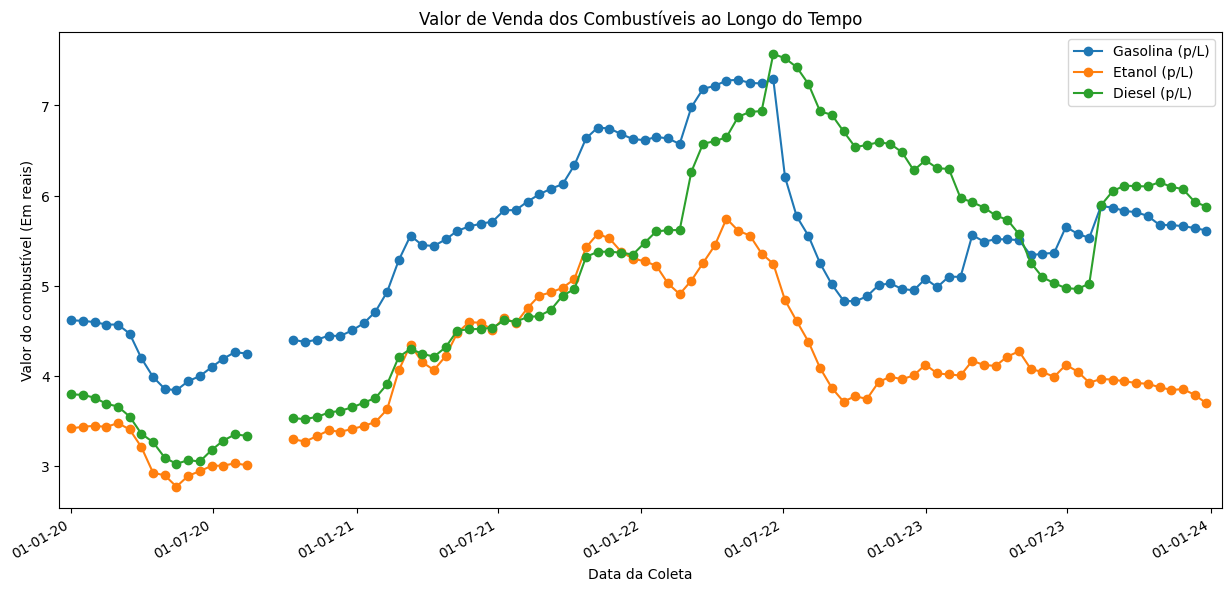

In [4]:
# 2.0. Valor de Venda dos Combustíveis ao Longo do Tempo

temp_df = anula_outliers_colunas_selecionadas(df, ['Data da Coleta',
                                                   'Valor de Venda Gasolina (p/L)', 
                                                   'Valor de Venda Etanol (p/L)',
                                                   'Valor de Venda Diesel (p/L)'], 
                                                   intervalo_de_corte_outliers)

temp_df = media_intervalo(temp_df, intervalo_de_agrupamento)

# --- #

# Convertendo a coluna 'Data da Coleta' de string para datetime
temp_df['Data da Coleta'] = pd.to_datetime(temp_df['Data da Coleta'], format='%Y%m%d')

# Criando o plot
plt.figure(figsize=(15, 7))
plt.plot(temp_df['Data da Coleta'], temp_df['Valor de Venda Gasolina (p/L)'], label='Gasolina (p/L)', marker='o', linestyle='-')
plt.plot(temp_df['Data da Coleta'], temp_df['Valor de Venda Etanol (p/L)'], label='Etanol (p/L)', marker='o', linestyle='-')
plt.plot(temp_df['Data da Coleta'], temp_df['Valor de Venda Diesel (p/L)'], label='Diesel (p/L)', marker='o', linestyle='-')

# Formatando o eixo x
ax = plt.gca()
# Estendendo os limites para antes e depois das datas desejadas
data_inicio = pd.Timestamp('2020-01-01') - pd.Timedelta(days=15)  # 15 dias antes
data_fim = pd.Timestamp('2023-12-31') + pd.Timedelta(days=15)  # 15 dias depois
ax.set_xlim([data_inicio, data_fim])

ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%d-%m-%y'))
plt.gcf().autofmt_xdate() # Auto formatar as datas para evitar sobreposição

# Adicionando título e labels
plt.title('Valor de Venda dos Combustíveis ao Longo do Tempo')
plt.xlabel('Data da Coleta')
plt.ylabel('Valor do combustível (Em reais)')
plt.legend()

# Mostrar o gráfico
plt.show()

Insights:
- A ausência de dados no segundo semestre de 2020 foi causada, provavelmente, pela pandemia.
- Os preços dos combustíveis têm movimento semelhante ao longo do tempo, indicando uma forte correlação entre as variáveis.
- Há um aumento expressivo para o preço de todos os combustíveis a partir do começo de 2021, preços esses que só começaram a cair a partir do segundo semestre de 2022.

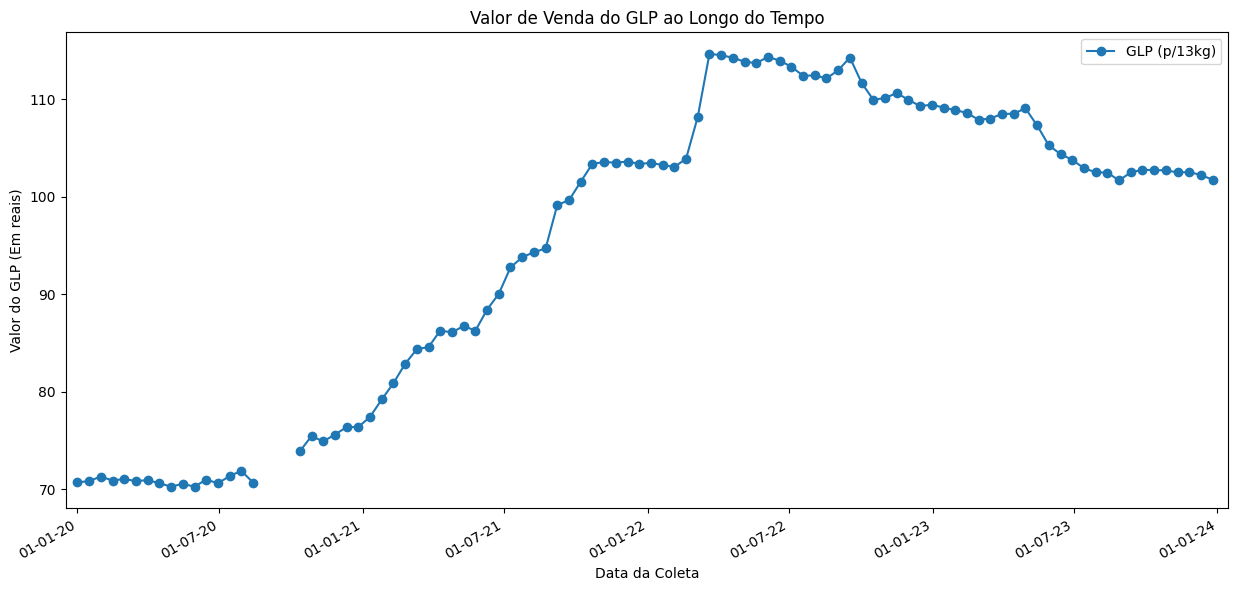

In [5]:
# 2.1. Valor de Venda do GLP ao Longo do Tempo

temp_df = anula_outliers_colunas_selecionadas(df, ['Data da Coleta',
                                                   'Valor de Venda GLP (p/13kg)'], 
                                                   intervalo_de_corte_outliers)

temp_df = media_intervalo(temp_df, intervalo_de_agrupamento)

# --- #

# Convertendo a coluna 'Data da Coleta' de string para datetime
temp_df['Data da Coleta'] = pd.to_datetime(temp_df['Data da Coleta'], format='%Y%m%d')

# Criando o plot
plt.figure(figsize=(15, 7))
plt.plot(temp_df['Data da Coleta'], temp_df['Valor de Venda GLP (p/13kg)'], label='GLP (p/13kg)', marker='o', linestyle='-')

# Formatando o eixo x
ax = plt.gca()
# Estendendo os limites para antes e depois das datas desejadas
data_inicio = pd.Timestamp('2020-01-01') - pd.Timedelta(days=15)  # 15 dias antes
data_fim = pd.Timestamp('2023-12-31') + pd.Timedelta(days=15)  # 15 dias depois
ax.set_xlim([data_inicio, data_fim])

ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%d-%m-%y'))
plt.gcf().autofmt_xdate() # Auto formatar as datas para evitar sobreposição

# Adicionando título e labels
plt.title('Valor de Venda do GLP ao Longo do Tempo')
plt.xlabel('Data da Coleta')
plt.ylabel('Valor do GLP (Em reais)')
plt.legend()

# Mostrar o gráfico
plt.show()

Insights:
- A ausência de dados no segundo semestre de 2020 foi causada, provavelmente, pela pandemia.
- Novamente, é notável o aumento do preço do GLP a partir do começo de 2021, preço esse que começa a sofrer uma leve queda a partir do meio de 2022

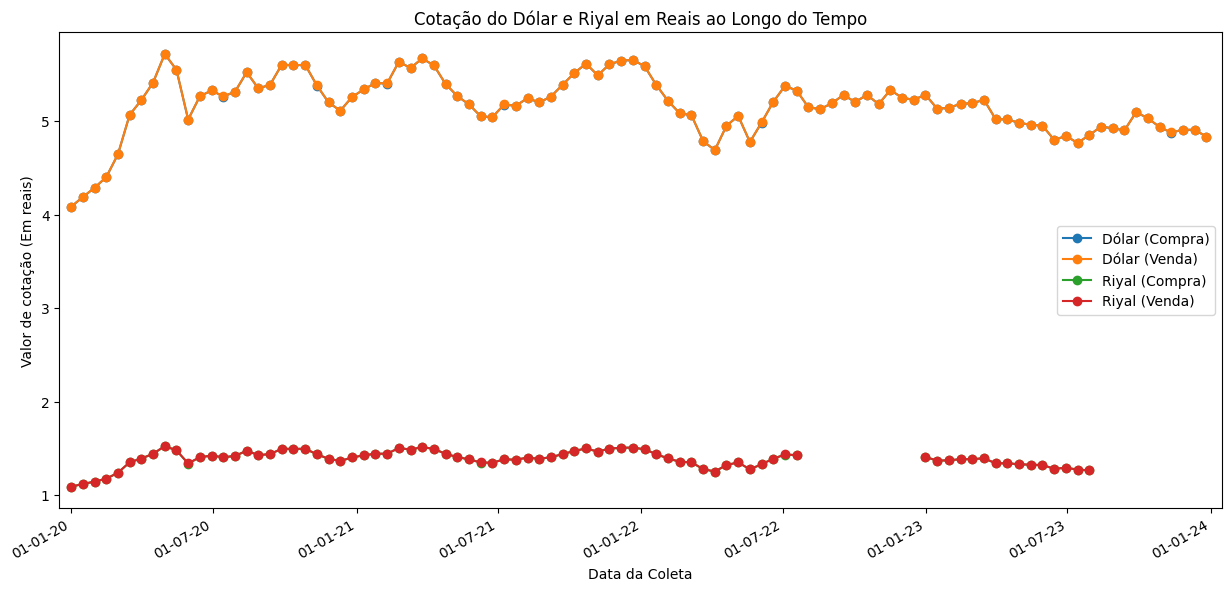

In [19]:
# 2.2. Cotação do dólar e riyal ao Longo do Tempo

temp_df = anula_outliers_colunas_selecionadas(df, ['Data da Coleta',
                                                   'Cotação dolar em Real (Compra)',
                                                   'Cotação dolar em Real (Venda)',
                                                   'Cotação riyal em Real (Compra)',
                                                   'Cotação riyal em Real (Venda)'
                                                   ], 
                                                   intervalo_de_corte_outliers)

temp_df = media_intervalo(temp_df, intervalo_de_agrupamento)

# --- #

# Convertendo a coluna 'Data da Coleta' de string para datetime
temp_df['Data da Coleta'] = pd.to_datetime(temp_df['Data da Coleta'], format='%Y%m%d')

# Criando o plot
plt.figure(figsize=(15, 7))
plt.plot(temp_df['Data da Coleta'], temp_df['Cotação dolar em Real (Compra)'], label='Dólar (Compra)', marker='o', linestyle='-')
plt.plot(temp_df['Data da Coleta'], temp_df['Cotação dolar em Real (Venda)'], label='Dólar (Venda)', marker='o', linestyle='-')
plt.plot(temp_df['Data da Coleta'], temp_df['Cotação riyal em Real (Compra)'], label='Riyal (Compra)', marker='o', linestyle='-')
plt.plot(temp_df['Data da Coleta'], temp_df['Cotação riyal em Real (Venda)'], label='Riyal (Venda)', marker='o', linestyle='-')

# Formatando o eixo x
ax = plt.gca()
# Estendendo os limites para antes e depois das datas desejadas
data_inicio = pd.Timestamp('2020-01-01') - pd.Timedelta(days=15)  # 15 dias antes
data_fim = pd.Timestamp('2023-12-31') + pd.Timedelta(days=15)  # 15 dias depois
ax.set_xlim([data_inicio, data_fim])

ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%d-%m-%y'))
plt.gcf().autofmt_xdate() # Auto formatar as datas para evitar sobreposição

# Adicionando título e labels
plt.title('Cotação do Dólar e Riyal em Reais ao Longo do Tempo')
plt.xlabel('Data da Coleta')
plt.ylabel('Valor de cotação (Em reais)')
plt.legend()

# Mostrar o gráfico
plt.show()

Insights:
- Existem alguns dados faltantes, entre meio e fim de 2022 e a partir do meio de 2023, para a moeda da Arabia Saudita. No entanto, ainda não foi confirmado o motivo da ausência desses dados. 
- É possível notar uma semelhança na movimentação das curvas.
- A dólar notavelmente têm valor mais "instavel" que o Ryial, apesar de fazerem movimentações semelhantes.

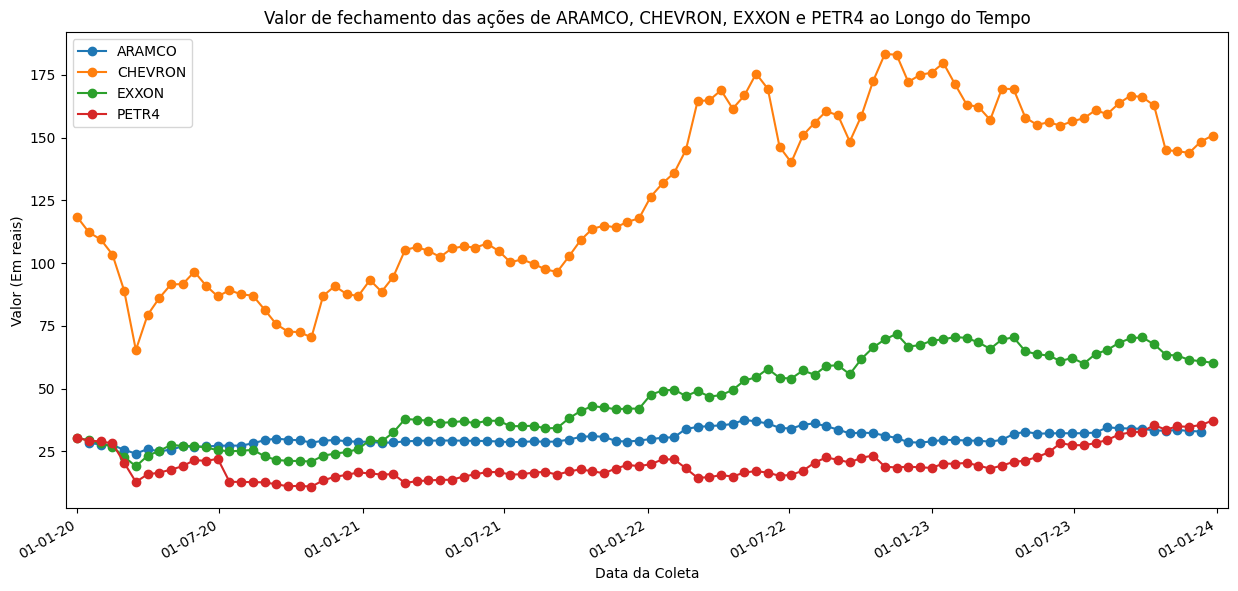

In [20]:
# 2.3. Valor de fechamento de ARAMCO, CHEVRON, EXXON e PETR4 ao Longo do Tempo
temp_df = anula_outliers_colunas_selecionadas(df, ['Data da Coleta', 
                                                   'Fechamento ARAMCO (em Riyais)', 
                                                   'Fechamento CHEVRON (em Reais)', 
                                                   'Fechamento EXXON (em Reais)', 
                                                   'Fechamento PETR4 (em Reais)'], 
                                                   intervalo_de_corte_outliers)
temp_df = media_intervalo(temp_df, intervalo_de_agrupamento)

# Convertendo a coluna 'Data da Coleta' de string para datetime
temp_df['Data da Coleta'] = pd.to_datetime(temp_df['Data da Coleta'], format='%Y%m%d')

# Criando o plot
plt.figure(figsize=(15, 7))
plt.plot(temp_df['Data da Coleta'], temp_df['Fechamento ARAMCO (em Riyais)'], label='ARAMCO', marker='o', linestyle='-')
plt.plot(temp_df['Data da Coleta'], temp_df['Fechamento CHEVRON (em Reais)'], label='CHEVRON', marker='o', linestyle='-')
plt.plot(temp_df['Data da Coleta'], temp_df['Fechamento EXXON (em Reais)'], label='EXXON', marker='o', linestyle='-')
plt.plot(temp_df['Data da Coleta'], temp_df['Fechamento PETR4 (em Reais)'], label='PETR4', marker='o', linestyle='-')

# Formatando o eixo x
ax = plt.gca()
# Estendendo os limites para antes e depois das datas desejadas
data_inicio = pd.Timestamp('2020-01-01') - pd.Timedelta(days=15) # 15 dias antes
data_fim = pd.Timestamp('2023-12-31') + pd.Timedelta(days=15) # 15 dias depois
ax.set_xlim([data_inicio, data_fim])
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%d-%m-%y'))
plt.gcf().autofmt_xdate() # Auto formatar as datas para evitar sobreposição

# Adicionando título e labels
plt.title('Valor de fechamento das ações de ARAMCO, CHEVRON, EXXON e PETR4 ao Longo do Tempo')
plt.xlabel('Data da Coleta')
plt.ylabel('Valor (Em reais)')
plt.legend()

# Mostrar o gráfico
plt.show()

Insights:
- A CHEVRON, visivelmente, têm um valor de fechamento maior que as demais petrolíferas. No entanto, também é notavel a maior volatilidade do valor dela.
- As demais petrolíferas mantém um valor de mercado estável com o tempo, com o início de um leve cresciemnto da EXXON a partir do começo de 2022.

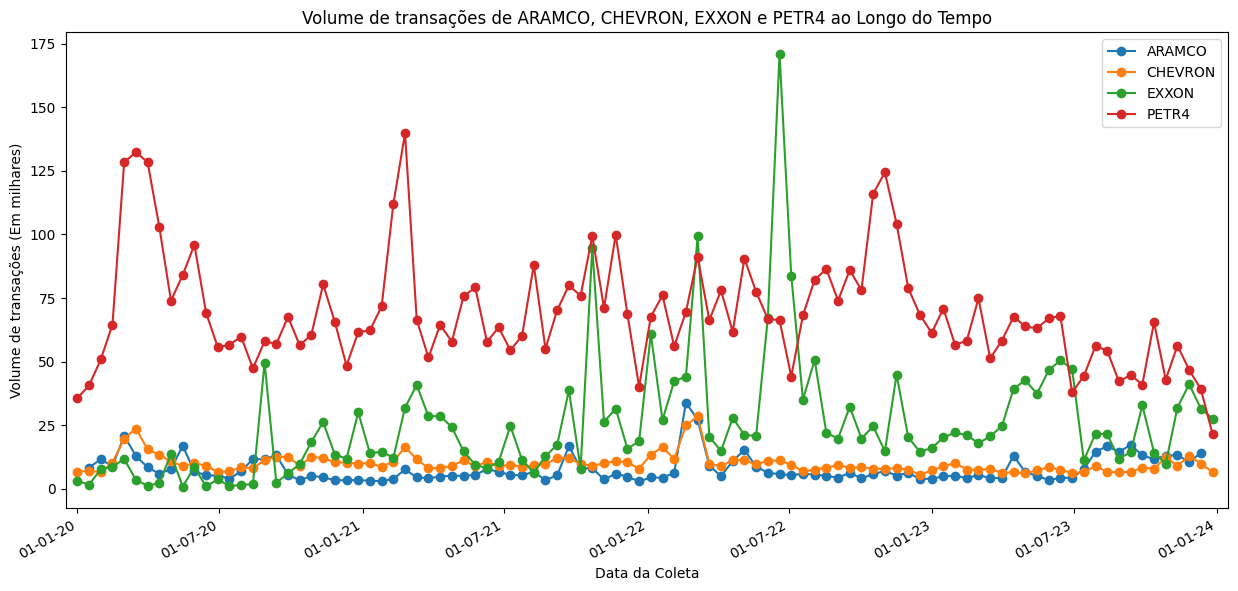

In [21]:
# 2.4. Volume de transações de ARAMCO, CHEVRON, EXXON e PETR4 ao Longo do Tempo

temp_df = anula_outliers_colunas_selecionadas(df, ['Data da Coleta',
                                                   'Volume de transações ARAMCO (Em milhares)', 
                                                   'Volume de transações CHEVRON (Em milhares)', 
                                                   'Volume de transações EXXON (Em milhares)', 
                                                   'Volume de transações PETR4 (Em milhares)'], 
                                                   intervalo_de_corte_outliers)

temp_df = media_intervalo(temp_df, intervalo_de_agrupamento)

# Convertendo a coluna 'Data da Coleta' de string para datetime
temp_df['Data da Coleta'] = pd.to_datetime(temp_df['Data da Coleta'], format='%Y%m%d')

# Criando o plot
plt.figure(figsize=(15, 7))
plt.plot(temp_df['Data da Coleta'], temp_df['Volume de transações ARAMCO (Em milhares)'], label='ARAMCO', marker='o', linestyle='-')
plt.plot(temp_df['Data da Coleta'], temp_df['Volume de transações CHEVRON (Em milhares)'], label='CHEVRON', marker='o', linestyle='-')
plt.plot(temp_df['Data da Coleta'], temp_df['Volume de transações EXXON (Em milhares)'], label='EXXON', marker='o', linestyle='-')
plt.plot(temp_df['Data da Coleta'], temp_df['Volume de transações PETR4 (Em milhares)'], label='PETR4', marker='o', linestyle='-')

# Formatando o eixo x
ax = plt.gca()
# Estendendo os limites para antes e depois das datas desejadas
data_inicio = pd.Timestamp('2020-01-01') - pd.Timedelta(days=15)  # 15 dias antes
data_fim = pd.Timestamp('2023-12-31') + pd.Timedelta(days=15)  # 15 dias depois
ax.set_xlim([data_inicio, data_fim])

ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%d-%m-%y'))
plt.gcf().autofmt_xdate() # Auto formatar as datas para evitar sobreposição

# Adicionando título e labels
plt.title('Volume de transações de ARAMCO, CHEVRON, EXXON e PETR4 ao Longo do Tempo')
plt.xlabel('Data da Coleta')
plt.ylabel('Volume de transações (Em milhares)')
plt.legend()

# Mostrar o gráfico
plt.show()

Insights:
- A Petrobras (PETR4) têm visivelmente um número de transações mais alto que as demais petrolíferas, também variando mais que as demais.
- Além disso, a EXXON também têm um número de transações maior e com maior variação, mas não se compara a Petrobras.
- Por fim, as demais petrolíferas seguem uma linha mais estável e com menor número de transações

# Gerando os gráficos de correlação

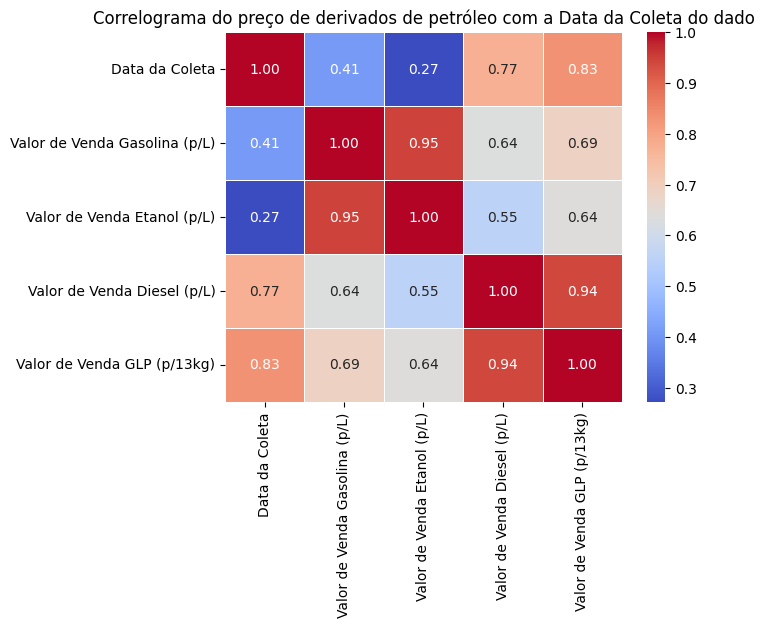

In [272]:
# 3.0. Correlação entre cada um dos combustíveis e GLP

temp_df = anula_outliers_colunas_selecionadas(df, ['Data da Coleta',
                                                   'Valor de Venda Gasolina (p/L)', 
                                                   'Valor de Venda Etanol (p/L)',
                                                   'Valor de Venda Diesel (p/L)',
                                                   'Valor de Venda GLP (p/13kg)'], 
                                                   intervalo_de_corte_outliers)


# --- #

# Calculando a matriz de correlação
correlation_matrix = temp_df.corr()

# Criando o heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlograma do preço de derivados de petróleo com a Data da Coleta do dado')
plt.show()

Insights:
- A forte correlação positiva entre a data de coleta e o Valor de venda do GLP indica que o preço de venda do gás de cozinha está aumentando com o passar do tempo. O mesmo processo também ocorre com os demais derivados de petróleo, mas com correlação não tão forte.
- Também é notável a forte correlação positiva entre os preços da gasolina e do etanol e entre os preços do diesel e do GLP. Abrindo possibilidade para futuras investigações.

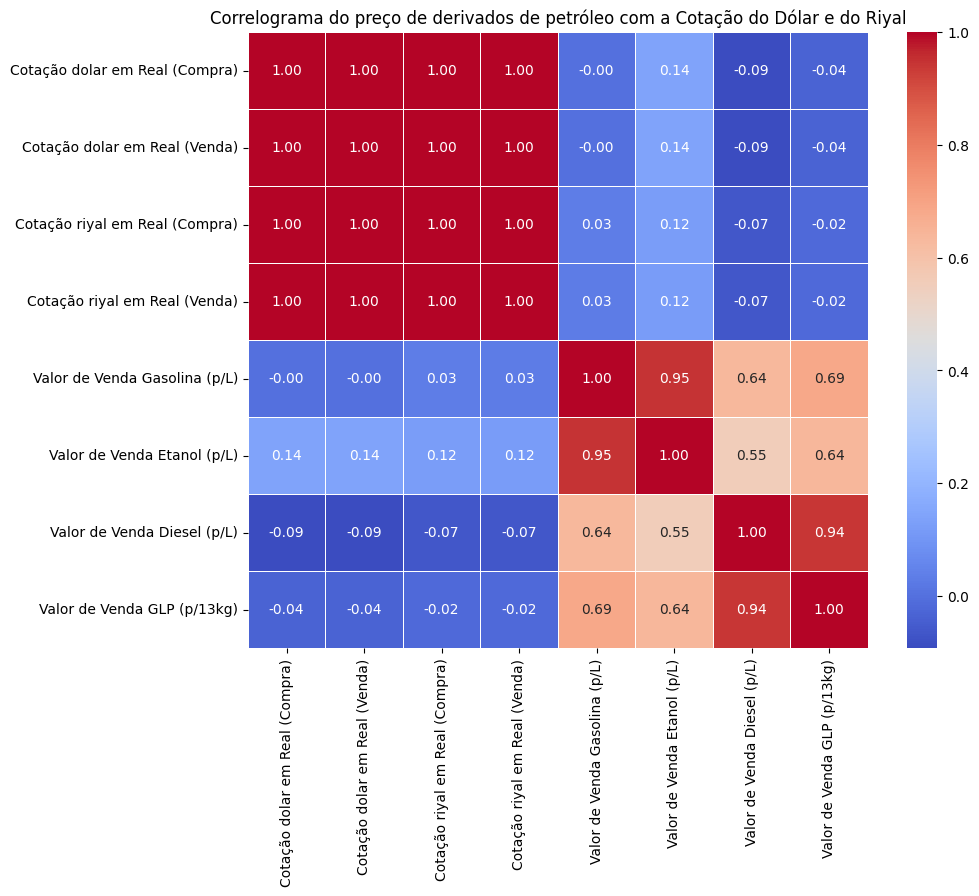

In [22]:
# 3.1. Correlação do preço de derivados de petróleo com a Cotação do Dólar e do Riyal

temp_df = anula_outliers_colunas_selecionadas(df, ['Cotação dolar em Real (Compra)',
                                                   'Cotação dolar em Real (Venda)',
                                                   'Cotação riyal em Real (Compra)',
                                                   'Cotação riyal em Real (Venda)',
                                                   'Valor de Venda Gasolina (p/L)', 
                                                   'Valor de Venda Etanol (p/L)',
                                                   'Valor de Venda Diesel (p/L)',
                                                   'Valor de Venda GLP (p/13kg)'], 
                                                   intervalo_de_corte_outliers)

# --- #

# Calculando a matriz de correlação
correlation_matrix = temp_df.corr()

# Criando o heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlograma do preço de derivados de petróleo com a Cotação do Dólar e do Riyal')
plt.show()

Insights:
- A correlação entre o valor do Dólar e do Riyal para os valores de venda dos derivados de petróleo são quase nulos
- A correlação entre o valor do Dólar e do Riyal é extremamente forte

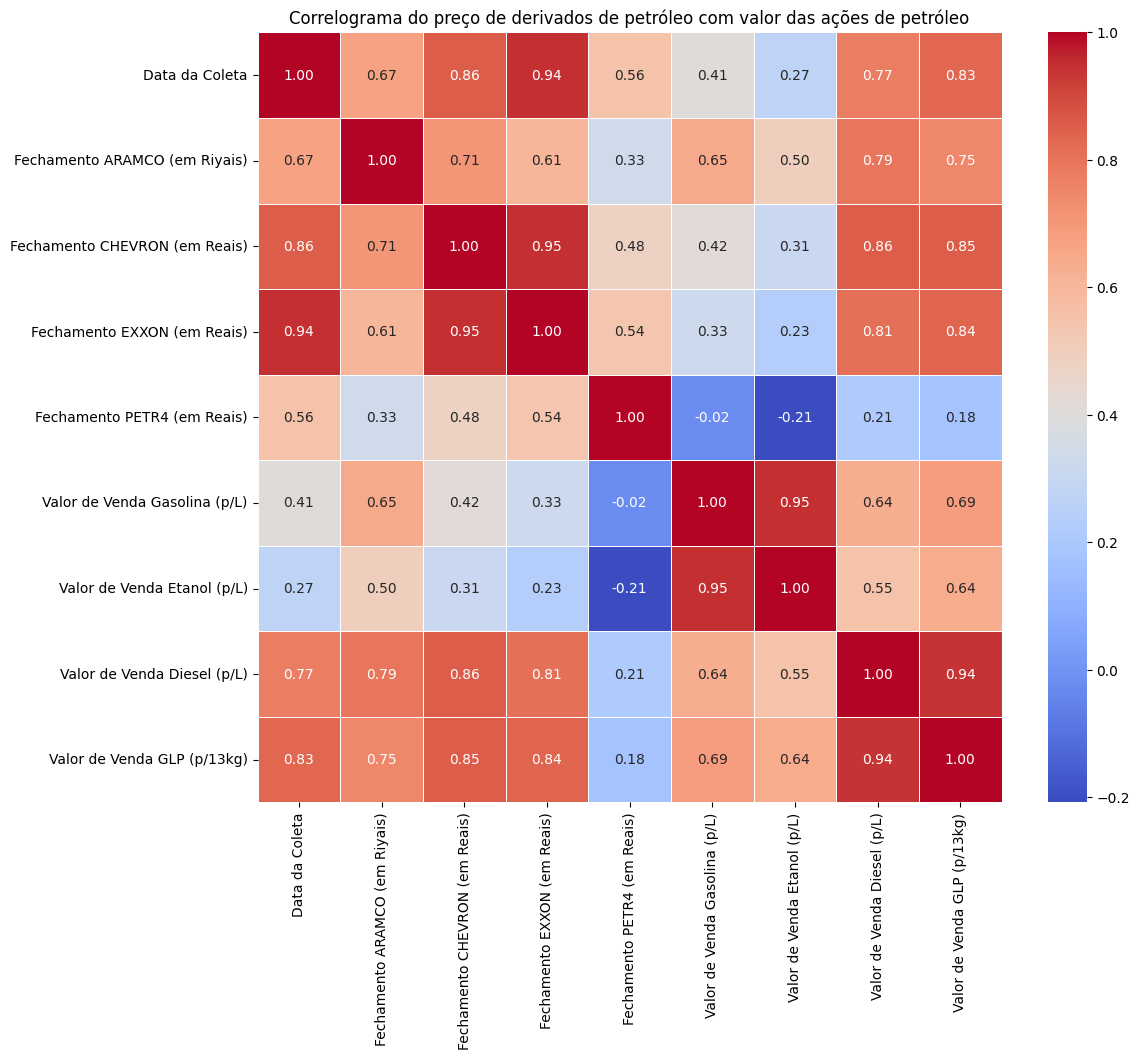

In [23]:
# 3.2. Correlação do preço de derivados de petróleo com o valor das ações do petróleo e o volume de transações das ações de petróleo

temp_df = anula_outliers_colunas_selecionadas(df, ['Data da Coleta', 
                                                   'Fechamento ARAMCO (em Riyais)', 
                                                   'Fechamento CHEVRON (em Reais)', 
                                                   'Fechamento EXXON (em Reais)', 
                                                   'Fechamento PETR4 (em Reais)',
                                                   'Valor de Venda Gasolina (p/L)', 
                                                   'Valor de Venda Etanol (p/L)',
                                                   'Valor de Venda Diesel (p/L)',
                                                   'Valor de Venda GLP (p/13kg)'], 
                                                   intervalo_de_corte_outliers)

# --- #

# Calculando a matriz de correlação
correlation_matrix = temp_df.corr()

# Criando o heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlograma do preço de derivados de petróleo com valor das ações de petróleo')
plt.show()

Insights:
- As correlações entre os valores de fechamento das petrolíferas e o preço do Diesel e do GLP é relativamente forte, enquanto a correlação delas com os valores da Gasolina e do Etanol são mais fracos. A única com relações mais forte com a Gasolina e Etanol é a ARAMCO, mas ainda não é uma relação extremamente forte.

Text(0.5, 1.0, 'Correlograma do preço de derivados de petróleo com o volume de transações de petróleo')

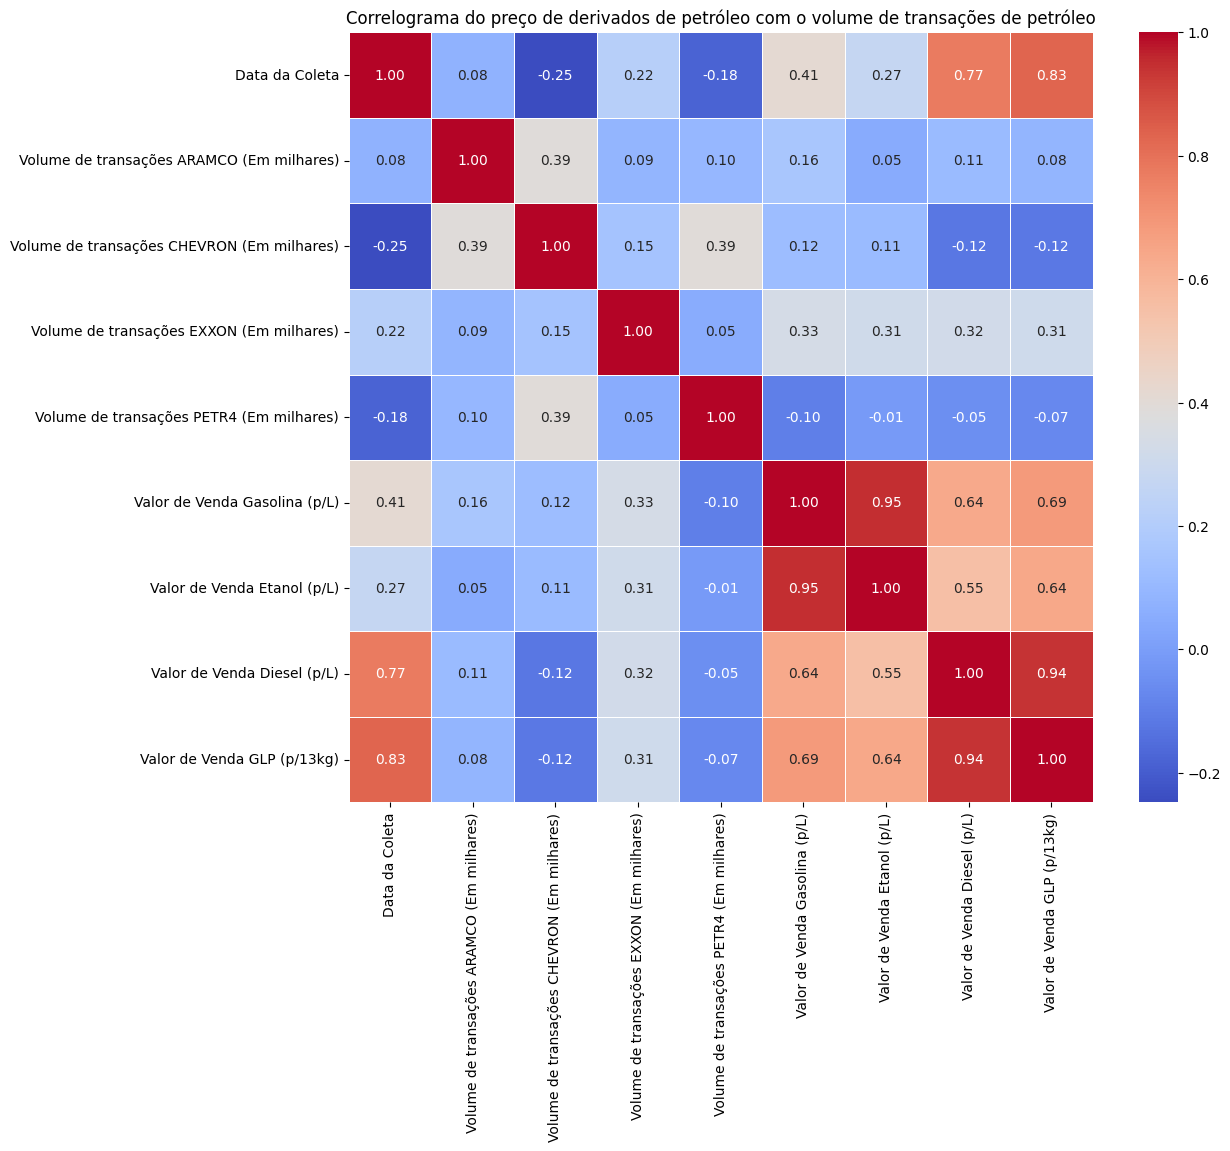

In [24]:
# 3.2. Correlação do preço de derivados de petróleo com o valor das ações do petróleo e o volume de transações das ações de petróleo

temp_df = anula_outliers_colunas_selecionadas(df, ['Data da Coleta', 
                                                   'Volume de transações ARAMCO (Em milhares)',
                                                   'Volume de transações CHEVRON (Em milhares)',
                                                   'Volume de transações EXXON (Em milhares)',
                                                   'Volume de transações PETR4 (Em milhares)',
                                                   'Valor de Venda Gasolina (p/L)', 
                                                   'Valor de Venda Etanol (p/L)',
                                                   'Valor de Venda Diesel (p/L)',
                                                   'Valor de Venda GLP (p/13kg)'], 
                                                   intervalo_de_corte_outliers)

# --- #

# Calculando a matriz de correlação
correlation_matrix = temp_df.corr()

# Criando o heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlograma do preço de derivados de petróleo com o volume de transações de petróleo')

Insights:
- Enquanto isso, o volume de transações têm correlação extremamente fraca para todos os casos, sendo um pouco maior na EXXON, mas também sem valores que exibem uma correlalação minimamente forte. 

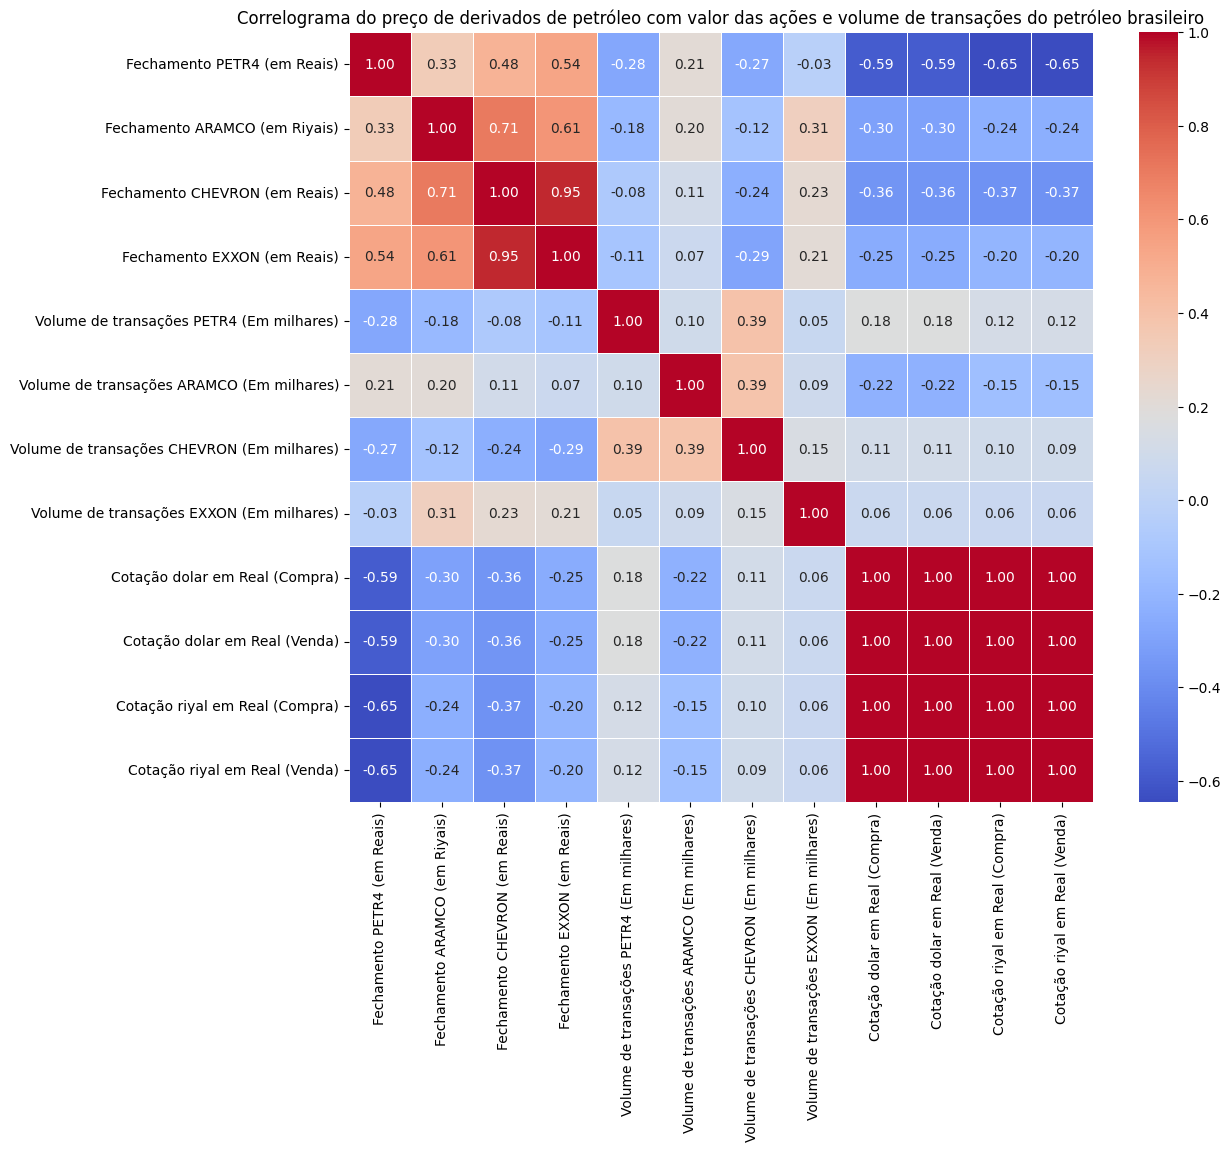

In [25]:
# 3.2. Correlação do preço de derivados de petróleo com a valor das ações do petróleo e o volume de transações das ações de petróleo

temp_df = anula_outliers_colunas_selecionadas(df, ['Fechamento PETR4 (em Reais)',
                                                   'Fechamento ARAMCO (em Riyais)',
                                                   'Fechamento CHEVRON (em Reais)',
                                                   'Fechamento EXXON (em Reais)',
                                                   'Volume de transações PETR4 (Em milhares)',
                                                   'Volume de transações ARAMCO (Em milhares)',
                                                   'Volume de transações CHEVRON (Em milhares)',
                                                   'Volume de transações EXXON (Em milhares)',
                                                   'Cotação dolar em Real (Compra)',
                                                   'Cotação dolar em Real (Venda)',
                                                   'Cotação riyal em Real (Compra)',
                                                   'Cotação riyal em Real (Venda)'], 
                                                   intervalo_de_corte_outliers)

# --- #

# Calculando a matriz de correlação
correlation_matrix = temp_df.corr()

# Criando o heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlograma do preço de derivados de petróleo com valor das ações e volume de transações do petróleo brasileiro')
plt.show()